# Redes de Convolução Dilatadas

Nesta aula, vamos ver como usar redes de convolução para prever o tempo. Para isso, vamos usar um tipo de CNN que suporta uma operação diferente de convolução, a _convolução dilatada causal_.

In [1]:
from __future__ import print_function, division

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Introdução

CNNs foram projetadas principalmente para processamento espacial. Elas, contudo, são usadas também como sucesso para entradas de natureza sequencial, como frases, áudio etc. Nestes casos, elas tiram proveito do contexto observado na sequência, sem lidar realmente com o seu encadeamento sequêncial. Contudo, mais recentemente, arquiteturas têm sido propostas que são capazes de lidar mesmo com a natureza sequencial da informação. Um exemplo são as CNNs dilatadas (DC-CNNs), ou seja, CNNs com operações de convolução causais dilatadas.

A ideia geral das DC-CNNs é explorar o contexto da informação considerando sua direção causal. Em termos práticos, operações de convolução nestas CNNs são restritas a apenas uma direção. É mais fácil entender isso com um exemplo. Abaixo, temos o esquema de uma convolução causal 1-D de largura 2. Ou seja, cada neurônio observa duas entradas. Como a convolução é causal, note que o $t$-ésimo neurônio só pode observar entradas $t$ e $t-1$.

<img src="images/WaveNet_causalconv.png" alt="Convolução causal" style="width: 600px;"/>

Este tipo de operação permite a previsão de uma saída, pela observação de entradas anteriores a ela. Contudo, note no exemplo, que para observar 5 entradas, a rede precisa de 3 camadas ocultas. Para observar uma série com 16 entradas, seriam necessárias 14 camadas, tornando a rede rapidamente  inviável para sequencias maiores.

Uma forma de resolver este problema é atraves de _convoluções dilatadas_, ou seja convoluções aplicadas à entrada com intervalos de tamanhos pré-definidos. Por exemplo, com apenas 3 camadas é possível observar 16 entradas se cada camada possuir o dobro de intervalos da camada anterior, como visto abaixo:

<img src="images/WaveNet_dilatedconv.png" alt="Convolução causal" style="width: 600px;"/>

A quantidade de intervalos entre duas observações é chamada _fator de dilatação_. Uma convolução normal pode ser vista como uma convolução em que o fator de dilatação $k = 1$. Com $k=2$, a convolução saltaria uma a cada duas entradas. Com $k=4$, seriam saltadas 3 entradas. 

Estas operações de convolução possibilitam que se aumente o "campo receptivo" de um neurônio exponencialmente com um aumento apenas linear do número de parâmetros. Assim, é possível se explorar a sequência de elementos tanto de forma detalhada quanto geral, sem grande custo processamento.

Assim, usando convoluções causais dilatadas, é possível usar CNNs para preverem o próximo elemento de uma sequência, tornando possível o seu uso como previsores temporais, como ilustrado abaixo:

<img src="images/dilation_animation.gif" alt="Animação de dilations" style="width: 500px;"/>

Neste notebook, vamos implementar esta estratégia de previsão.

### Uma arquitetura CNN dilatada

Em particular, vamos implementar a rede _seriesnet_, uma DN-CNN com a arquitetura ilustrada a seguir:

<img src="images/dilatedCNN.png" alt="CNN dilatada" style="width: 500px;"/>

Nesta arquitetura, em particular, 7 camadas são empilhadas. Cada camada corresponde a um bloco com diferente fator de dilatação (bloco DC-CNN). A saída de todos os blocos é somada e transformada por uma operação _relu_. O resultado é então combinado em uma convolução de largura 1 que gera a previsão $\hat{y}$. 

Cada bloco DC-CNN corresponde a um conjunto de filtros de convolução causal dilatada, com saída tanto para o próximo bloco quanto para o somador final. Ambas as saídas ainda são transformadas por uma operação relu e combinadas via camadas de convolução 1x1. A saída para o próximo bloco é residual. A seguir, temos a implementação desta arquitetura em Keras.

In [3]:
import tensorflow as tf

#Se vocês estiverem tendo crashes estranhos quando rodarem as convolucoes, 
#pode ser um problema do CUDA nao estar gerenciando bem a memoria. Descomentem essas linhas nesse caso
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.Session(config=config)

from keras.layers import Conv1D, Input, Add, Activation, Dropout
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.initializers import TruncatedNormal
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras import optimizers



E:\Anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
def DC_CNN_Block(nb_filter, filter_length, dilation, l2_layer_reg):
    def block(block_input):        
        residual =    block_input
        
        layer_out =   Conv1D(filters=nb_filter, kernel_size=filter_length, 
                      dilation_rate=dilation, 
                      activation='linear', padding='causal', use_bias=False,
                      kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, 
                      seed=42), kernel_regularizer=l2(l2_layer_reg))(block_input)                    
        selu_out =    Activation('selu')(layer_out)
        
        skip_out =    Conv1D(1,1, activation='linear', use_bias=False, 
                      kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, 
                      seed=42), kernel_regularizer=l2(l2_layer_reg))(selu_out)
        
        c1x1_out =    Conv1D(1,1, activation='linear', use_bias=False, 
                      kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, 
                      seed=42), kernel_regularizer=l2(l2_layer_reg))(selu_out)
                      
        block_out =   Add()([residual, c1x1_out])
        
        return block_out, skip_out
    return block

In [28]:
def DC_CNN_Model(length):
    visible = Input(shape=(length, 1))
    
    l1a, l1b = DC_CNN_Block(32,2,1,0.001)(visible)    
    l2a, l2b = DC_CNN_Block(32,2,2,0.001)(l1a) 
    l3a, l3b = DC_CNN_Block(32,2,4,0.001)(l2a)
    l4a, l4b = DC_CNN_Block(32,2,8,0.001)(l3a)
    l5a, l5b = DC_CNN_Block(32,2,16,0.001)(l4a)
    l6a, l6b = DC_CNN_Block(32,2,32,0.001)(l5a)
    dp1 = Dropout(0.2)(l6b)
    l7a, l7b = DC_CNN_Block(32,2,64,0.001)(l6a)
    dp2 = Dropout(0.2)(l7b)

    l8 =   Add()([l1b, l2b, l3b, l4b, l5b, dp1, dp2])  
    
    l9 =   Activation('relu')(l8)
           
    yhat =  Conv1D(1,1, activation='linear', use_bias=False, 
            kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42),
            kernel_regularizer=l2(0.001))(l9)

    model = Model(inputs=visible, outputs=yhat)
    
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0)

    model.compile(loss='mae', optimizer=adam, metrics=['mse'])
    return model

### Usando CNNs dilatadas para previsão de séries de tempo

Para testar nosso modelo, vamos usar uma série com informaçoes sobre o número de passageiros em vôos nos EUA entre 1949 e 1961.

In [6]:
import pandas as pd

In [7]:
airline = pd.read_csv('data/airline.csv')

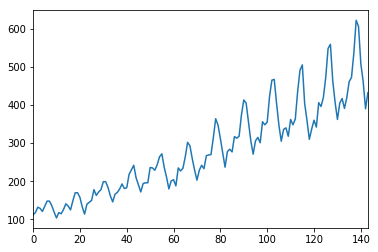

In [8]:
airline['passengers'].plot()

Esta série apresenta clara sazonalidade e uma tendência de crescimento. A seguir, Vamos agora fazer uma previsão para um horizonte de 40 dias:

In [9]:
forecast_horizon = 40

In [10]:
Xpast = airline['passengers'].iloc[:-forecast_horizon]
Xreal = airline['passengers'].iloc[-forecast_horizon:] 

In [11]:
Xpast = np.atleast_2d(np.asarray(Xpast)).T

In [12]:
length = len(Xpast)-1

In [13]:
model = DC_CNN_Model(length)

In [14]:
X = Xpast[:-1].reshape(1,length,1)
y = Xpast[1:].reshape(1,length,1)    

In [15]:
print(X[0,:5,:].T)
print(y[0,:5,:].T)
model.summary()

[[112 118 132 129 121]]
[[118 132 129 121 135]]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 103, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 103, 32)      64          input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 103, 32)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 103, 1)       32          activation_1[0][0]               
_____________________________________________________________

In [16]:
model.fit(X, y, epochs=500)

Epoch 1/500
1/1 [==============================] - 4s 4s/step - loss: 228.4865 - mean_squared_error: 59145.7773
Epoch 2/500
1/1 [==============================] - 0s 31ms/step - loss: 228.3858 - mean_squared_error: 59093.4375
Epoch 3/500
1/1 [==============================] - 0s 13ms/step - loss: 228.2773 - mean_squared_error: 59036.9805
Epoch 4/500
1/1 [==============================] - 0s 13ms/step - loss: 228.1710 - mean_squared_error: 58981.7461
Epoch 5/500
1/1 [==============================] - 0s 16ms/step - loss: 228.0708 - mean_squared_error: 58929.6328
Epoch 6/500
1/1 [==============================] - 0s 14ms/step - loss: 227.9783 - mean_squared_error: 58881.5000
Epoch 7/500
1/1 [==============================] - 0s 13ms/step - loss: 227.8943 - mean_squared_error: 58837.7656
Epoch 8/500
1/1 [==============================] - 0s 15ms/step - loss: 227.8192 - mean_squared_error: 58798.6562
Epoch 9/500
1/1 [==============================] - 0s 14ms/step - loss: 227.7531 - mean_sq

Epoch 73/500
1/1 [==============================] - 0s 14ms/step - loss: 224.9190 - mean_squared_error: 57294.5156
Epoch 74/500
1/1 [==============================] - 0s 12ms/step - loss: 224.4628 - mean_squared_error: 57060.3789
Epoch 75/500
1/1 [==============================] - 0s 12ms/step - loss: 223.9421 - mean_squared_error: 56793.8008
Epoch 76/500
1/1 [==============================] - 0s 12ms/step - loss: 223.3505 - mean_squared_error: 56491.7070
Epoch 77/500
1/1 [==============================] - 0s 18ms/step - loss: 222.6808 - mean_squared_error: 56150.8477
Epoch 78/500
1/1 [==============================] - 0s 17ms/step - loss: 221.9259 - mean_squared_error: 55767.8555
Epoch 79/500
1/1 [==============================] - 0s 14ms/step - loss: 221.0775 - mean_squared_error: 55338.8242
Epoch 80/500
1/1 [==============================] - 0s 15ms/step - loss: 220.1259 - mean_squared_error: 54859.5586
Epoch 81/500
1/1 [==============================] - 0s 15ms/step - loss: 219.060

Epoch 145/500
1/1 [==============================] - 0s 15ms/step - loss: 30.2466 - mean_squared_error: 1344.3521
Epoch 146/500
1/1 [==============================] - 0s 18ms/step - loss: 30.2728 - mean_squared_error: 1349.4456
Epoch 147/500
1/1 [==============================] - 0s 13ms/step - loss: 30.3722 - mean_squared_error: 1366.4508
Epoch 148/500
1/1 [==============================] - 0s 16ms/step - loss: 30.4900 - mean_squared_error: 1384.9662
Epoch 149/500
1/1 [==============================] - 0s 14ms/step - loss: 30.5384 - mean_squared_error: 1395.8494
Epoch 150/500
1/1 [==============================] - 0s 14ms/step - loss: 30.4843 - mean_squared_error: 1395.7004
Epoch 151/500
1/1 [==============================] - 0s 14ms/step - loss: 30.3370 - mean_squared_error: 1384.0156
Epoch 152/500
1/1 [==============================] - 0s 15ms/step - loss: 30.1004 - mean_squared_error: 1362.3632
Epoch 153/500
1/1 [==============================] - 0s 16ms/step - loss: 29.8010 - mean

Epoch 217/500
1/1 [==============================] - 0s 15ms/step - loss: 23.3770 - mean_squared_error: 952.8545
Epoch 218/500
1/1 [==============================] - 0s 16ms/step - loss: 23.3304 - mean_squared_error: 952.0731
Epoch 219/500
1/1 [==============================] - 0s 14ms/step - loss: 23.2773 - mean_squared_error: 948.8218
Epoch 220/500
1/1 [==============================] - 0s 14ms/step - loss: 23.2176 - mean_squared_error: 943.3456
Epoch 221/500
1/1 [==============================] - 0s 17ms/step - loss: 23.1611 - mean_squared_error: 937.3992
Epoch 222/500
1/1 [==============================] - 0s 16ms/step - loss: 23.1168 - mean_squared_error: 932.1378
Epoch 223/500
1/1 [==============================] - 0s 14ms/step - loss: 23.0731 - mean_squared_error: 929.5473
Epoch 224/500
1/1 [==============================] - 0s 13ms/step - loss: 23.0214 - mean_squared_error: 929.2053
Epoch 225/500
1/1 [==============================] - 0s 14ms/step - loss: 22.9797 - mean_squared

Epoch 290/500
1/1 [==============================] - 0s 14ms/step - loss: 20.7864 - mean_squared_error: 776.1977
Epoch 291/500
1/1 [==============================] - 0s 13ms/step - loss: 20.7561 - mean_squared_error: 774.3492
Epoch 292/500
1/1 [==============================] - 0s 18ms/step - loss: 20.7232 - mean_squared_error: 771.1108
Epoch 293/500
1/1 [==============================] - 0s 14ms/step - loss: 20.6924 - mean_squared_error: 766.6601
Epoch 294/500
1/1 [==============================] - 0s 16ms/step - loss: 20.6603 - mean_squared_error: 766.8138
Epoch 295/500
1/1 [==============================] - 0s 14ms/step - loss: 20.6350 - mean_squared_error: 760.8188
Epoch 296/500
1/1 [==============================] - 0s 13ms/step - loss: 20.6015 - mean_squared_error: 759.5071
Epoch 297/500
1/1 [==============================] - 0s 15ms/step - loss: 20.5758 - mean_squared_error: 756.2319
Epoch 298/500
1/1 [==============================] - 0s 14ms/step - loss: 20.5540 - mean_squared

Epoch 363/500
1/1 [==============================] - 0s 15ms/step - loss: 19.2026 - mean_squared_error: 625.5781
Epoch 364/500
1/1 [==============================] - 0s 15ms/step - loss: 19.1892 - mean_squared_error: 622.4016
Epoch 365/500
1/1 [==============================] - 0s 15ms/step - loss: 19.1756 - mean_squared_error: 620.7713
Epoch 366/500
1/1 [==============================] - 0s 14ms/step - loss: 19.1527 - mean_squared_error: 619.8618
Epoch 367/500
1/1 [==============================] - 0s 14ms/step - loss: 19.1272 - mean_squared_error: 619.9368
Epoch 368/500
1/1 [==============================] - 0s 13ms/step - loss: 19.1189 - mean_squared_error: 620.9821
Epoch 369/500
1/1 [==============================] - 0s 16ms/step - loss: 19.0882 - mean_squared_error: 617.9388
Epoch 370/500
1/1 [==============================] - 0s 17ms/step - loss: 19.0711 - mean_squared_error: 615.9036
Epoch 371/500
1/1 [==============================] - 0s 15ms/step - loss: 19.0516 - mean_squared

Epoch 436/500
1/1 [==============================] - 0s 16ms/step - loss: 18.1856 - mean_squared_error: 554.9770
Epoch 437/500
1/1 [==============================] - 0s 16ms/step - loss: 18.1718 - mean_squared_error: 553.7438
Epoch 438/500
1/1 [==============================] - 0s 12ms/step - loss: 18.1614 - mean_squared_error: 553.0110
Epoch 439/500
1/1 [==============================] - 0s 13ms/step - loss: 18.1581 - mean_squared_error: 551.3994
Epoch 440/500
1/1 [==============================] - 0s 14ms/step - loss: 18.1719 - mean_squared_error: 557.8973
Epoch 441/500
1/1 [==============================] - 0s 13ms/step - loss: 18.1522 - mean_squared_error: 555.2693
Epoch 442/500
1/1 [==============================] - 0s 14ms/step - loss: 18.1201 - mean_squared_error: 549.3784
Epoch 443/500
1/1 [==============================] - 0s 13ms/step - loss: 18.1431 - mean_squared_error: 546.3438
Epoch 444/500
1/1 [==============================] - 0s 16ms/step - loss: 18.1097 - mean_squared

In [17]:
#model.summary()
X_test_initial = Xpast[1:].reshape(1,length,1)
X_trfit = model.predict(X_test_initial)

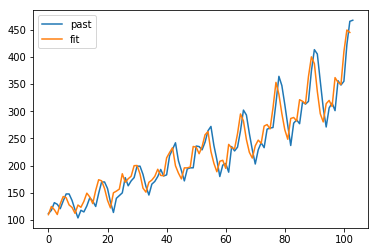

In [18]:
plt.plot(Xpast, label = 'past')
plt.plot(X_trfit.flatten(), label = 'fit')
plt.legend(loc = 'upper left')

In [19]:
preds = np.zeros(forecast_horizon)
preds[0] = model.predict(X_test_initial)[0,-1,0]

for i in range(1, forecast_horizon):
    X_test_i = np.append(X_test_initial[0,i:,:], preds[:i])
    preds[i] = model.predict(X_test_i.reshape(1, length, 1))[0,-1,0]

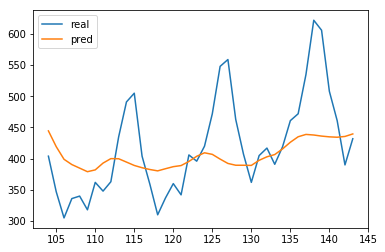

In [20]:
plt.plot(Xreal, label = 'real')
plt.plot(pd.DataFrame(preds, index=Xreal.index), label = 'pred')
plt.legend()

Juntando tudo:

In [25]:
def evaluate_timeseries(timeseries, predict_size, n_epochs = 3000):
    # timeseries input is 1-D numpy array
    # forecast_size is the forecast horizon
    
    # remove missing data
    timeseries = timeseries[~pd.isnull(timeseries)]

    length = len(timeseries)-1

    timeseries = np.atleast_2d(np.asarray(timeseries))
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T 

    model = DC_CNN_Model(length)
    print('\n\nModel input size',model.input_shape, 'output size' , model.output_shape)
    
    model.summary()

    # prime model
    X = timeseries[:-1].reshape(1,length,1)
    y = timeseries[1:].reshape(1,length,1)    
    model.fit(X, y, epochs=n_epochs)
    
    # get fit for training data
    X_test_initial = timeseries[1:].reshape(1,length,1)
    X_trfit = model.predict(X_test_initial) 
        
    # forecast is created by predicting next future 
    # value based on previous predictions
    preds = np.zeros(forecast_horizon)
    preds[0] = model.predict(X_test_initial)[0,-1,0]
    for i in range(1, forecast_horizon):
        X_test_i = np.append(X_test_initial[0,i:,:], preds[:i])
        preds[i] = model.predict(X_test_i.reshape(1, length, 1))[0,-1,0]
        
    return preds, X_trfit.flatten()

In [29]:
Xpred, Xfit = evaluate_timeseries(Xpast, forecast_horizon, n_epochs = 4000)



Model input size (None, 103, 1) output size (None, 103, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 103, 1)       0                                            
__________________________________________________________________________________________________
conv1d_67 (Conv1D)              (None, 103, 32)      64          input_4[0][0]                    
__________________________________________________________________________________________________
activation_25 (Activation)      (None, 103, 32)      0           conv1d_67[0][0]                  
__________________________________________________________________________________________________
conv1d_69 (Conv1D)              (None, 103, 1)       32          activation_25[0][0]              
________________________________________________

Epoch 1/4000
1/1 [==============================] - 2s 2s/step - loss: 228.4713 - mean_squared_error: 59139.5742
Epoch 2/4000
1/1 [==============================] - 0s 16ms/step - loss: 228.3808 - mean_squared_error: 59090.1602
Epoch 3/4000
1/1 [==============================] - 0s 15ms/step - loss: 228.2727 - mean_squared_error: 59033.3828
Epoch 4/4000
1/1 [==============================] - 0s 14ms/step - loss: 228.1788 - mean_squared_error: 58986.7852
Epoch 5/4000
1/1 [==============================] - 0s 15ms/step - loss: 228.0720 - mean_squared_error: 58929.7188
Epoch 6/4000
1/1 [==============================] - 0s 18ms/step - loss: 227.9761 - mean_squared_error: 58880.0078
Epoch 7/4000
1/1 [==============================] - 0s 13ms/step - loss: 227.8971 - mean_squared_error: 58839.1250
Epoch 8/4000
1/1 [==============================] - 0s 18ms/step - loss: 227.8190 - mean_squared_error: 58798.1172
Epoch 9/4000
1/1 [==============================] - 0s 16ms/step - loss: 227.7514 

Epoch 72/4000
1/1 [==============================] - 0s 16ms/step - loss: 224.0266 - mean_squared_error: 56850.7070
Epoch 73/4000
1/1 [==============================] - 0s 15ms/step - loss: 223.3864 - mean_squared_error: 56511.4180
Epoch 74/4000
1/1 [==============================] - 0s 15ms/step - loss: 222.8108 - mean_squared_error: 56220.5430
Epoch 75/4000
1/1 [==============================] - 0s 17ms/step - loss: 222.0052 - mean_squared_error: 55802.6328
Epoch 76/4000
1/1 [==============================] - 0s 16ms/step - loss: 221.2151 - mean_squared_error: 55411.1797
Epoch 77/4000
1/1 [==============================] - 0s 15ms/step - loss: 220.2072 - mean_squared_error: 54893.1523
Epoch 78/4000
1/1 [==============================] - 0s 15ms/step - loss: 219.1288 - mean_squared_error: 54361.9336
Epoch 79/4000
1/1 [==============================] - 0s 18ms/step - loss: 218.2367 - mean_squared_error: 53920.8867
Epoch 80/4000
1/1 [==============================] - 0s 14ms/step - loss

Epoch 143/4000
1/1 [==============================] - 0s 16ms/step - loss: 41.4651 - mean_squared_error: 2669.7917
Epoch 144/4000
1/1 [==============================] - 0s 16ms/step - loss: 35.2237 - mean_squared_error: 1974.3630
Epoch 145/4000
1/1 [==============================] - 0s 13ms/step - loss: 37.8098 - mean_squared_error: 2388.0071
Epoch 146/4000
1/1 [==============================] - 0s 13ms/step - loss: 34.1655 - mean_squared_error: 1839.4087
Epoch 147/4000
1/1 [==============================] - 0s 16ms/step - loss: 34.4010 - mean_squared_error: 1695.9330
Epoch 148/4000
1/1 [==============================] - 0s 14ms/step - loss: 36.8838 - mean_squared_error: 2033.1289
Epoch 149/4000
1/1 [==============================] - 0s 16ms/step - loss: 34.6132 - mean_squared_error: 1809.7908
Epoch 150/4000
1/1 [==============================] - 0s 15ms/step - loss: 39.4129 - mean_squared_error: 2443.1323
Epoch 151/4000
1/1 [==============================] - 0s 13ms/step - loss: 37.13

Epoch 215/4000
1/1 [==============================] - 0s 15ms/step - loss: 28.5552 - mean_squared_error: 1350.7133
Epoch 216/4000
1/1 [==============================] - 0s 14ms/step - loss: 30.3235 - mean_squared_error: 1428.7845
Epoch 217/4000
1/1 [==============================] - 0s 16ms/step - loss: 30.1615 - mean_squared_error: 1345.3352
Epoch 218/4000
1/1 [==============================] - 0s 18ms/step - loss: 29.1021 - mean_squared_error: 1441.8605
Epoch 219/4000
1/1 [==============================] - 0s 15ms/step - loss: 30.0013 - mean_squared_error: 1468.7273
Epoch 220/4000
1/1 [==============================] - 0s 15ms/step - loss: 27.2381 - mean_squared_error: 1149.2527
Epoch 221/4000
1/1 [==============================] - 0s 18ms/step - loss: 27.2145 - mean_squared_error: 1190.4375
Epoch 222/4000
1/1 [==============================] - 0s 15ms/step - loss: 26.7312 - mean_squared_error: 1234.9324
Epoch 223/4000
1/1 [==============================] - 0s 14ms/step - loss: 26.87

Epoch 287/4000
1/1 [==============================] - 0s 13ms/step - loss: 25.8289 - mean_squared_error: 1219.2321
Epoch 288/4000
1/1 [==============================] - 0s 15ms/step - loss: 25.0188 - mean_squared_error: 1092.8877
Epoch 289/4000
1/1 [==============================] - 0s 16ms/step - loss: 23.1027 - mean_squared_error: 983.9991
Epoch 290/4000
1/1 [==============================] - 0s 14ms/step - loss: 24.5630 - mean_squared_error: 949.4542
Epoch 291/4000
1/1 [==============================] - 0s 15ms/step - loss: 23.3841 - mean_squared_error: 966.5170
Epoch 292/4000
1/1 [==============================] - 0s 16ms/step - loss: 25.0351 - mean_squared_error: 1004.1374
Epoch 293/4000
1/1 [==============================] - 0s 17ms/step - loss: 22.8952 - mean_squared_error: 871.6525
Epoch 294/4000
1/1 [==============================] - 0s 16ms/step - loss: 24.4454 - mean_squared_error: 982.2814
Epoch 295/4000
1/1 [==============================] - 0s 14ms/step - loss: 23.6784 - 

Epoch 359/4000
1/1 [==============================] - 0s 18ms/step - loss: 22.3561 - mean_squared_error: 919.9187
Epoch 360/4000
1/1 [==============================] - 0s 14ms/step - loss: 21.5735 - mean_squared_error: 825.3518
Epoch 361/4000
1/1 [==============================] - 0s 18ms/step - loss: 21.1478 - mean_squared_error: 813.8896
Epoch 362/4000
1/1 [==============================] - 0s 15ms/step - loss: 22.0962 - mean_squared_error: 786.5319
Epoch 363/4000
1/1 [==============================] - 0s 15ms/step - loss: 22.0497 - mean_squared_error: 794.2018
Epoch 364/4000
1/1 [==============================] - 0s 15ms/step - loss: 22.1150 - mean_squared_error: 806.2982
Epoch 365/4000
1/1 [==============================] - 0s 15ms/step - loss: 21.8320 - mean_squared_error: 778.6101
Epoch 366/4000
1/1 [==============================] - 0s 17ms/step - loss: 23.0917 - mean_squared_error: 885.5303
Epoch 367/4000
1/1 [==============================] - 0s 17ms/step - loss: 21.5222 - mea

Epoch 431/4000
1/1 [==============================] - 0s 14ms/step - loss: 20.5428 - mean_squared_error: 713.6044
Epoch 432/4000
1/1 [==============================] - 0s 17ms/step - loss: 20.3382 - mean_squared_error: 698.6243
Epoch 433/4000
1/1 [==============================] - 0s 13ms/step - loss: 19.5205 - mean_squared_error: 644.5082
Epoch 434/4000
1/1 [==============================] - 0s 14ms/step - loss: 20.2168 - mean_squared_error: 675.5696
Epoch 435/4000
1/1 [==============================] - 0s 16ms/step - loss: 20.7943 - mean_squared_error: 679.3562
Epoch 436/4000
1/1 [==============================] - 0s 17ms/step - loss: 20.4633 - mean_squared_error: 680.4509
Epoch 437/4000
1/1 [==============================] - 0s 20ms/step - loss: 20.3889 - mean_squared_error: 680.6319
Epoch 438/4000
1/1 [==============================] - 0s 15ms/step - loss: 20.1846 - mean_squared_error: 655.6957
Epoch 439/4000
1/1 [==============================] - 0s 13ms/step - loss: 20.9885 - mea

Epoch 503/4000
1/1 [==============================] - 0s 13ms/step - loss: 19.9906 - mean_squared_error: 630.1505
Epoch 504/4000
1/1 [==============================] - 0s 16ms/step - loss: 20.1701 - mean_squared_error: 663.6423
Epoch 505/4000
1/1 [==============================] - 0s 12ms/step - loss: 19.9993 - mean_squared_error: 632.9122
Epoch 506/4000
1/1 [==============================] - 0s 18ms/step - loss: 20.2258 - mean_squared_error: 669.7747
Epoch 507/4000
1/1 [==============================] - 0s 14ms/step - loss: 19.1773 - mean_squared_error: 641.3574
Epoch 508/4000
1/1 [==============================] - 0s 16ms/step - loss: 20.0191 - mean_squared_error: 641.0015
Epoch 509/4000
1/1 [==============================] - 0s 15ms/step - loss: 19.6530 - mean_squared_error: 627.4789
Epoch 510/4000
1/1 [==============================] - 0s 16ms/step - loss: 19.0261 - mean_squared_error: 601.6501
Epoch 511/4000
1/1 [==============================] - 0s 17ms/step - loss: 19.4799 - mea

Epoch 575/4000
1/1 [==============================] - 0s 17ms/step - loss: 19.1208 - mean_squared_error: 612.0486
Epoch 576/4000
1/1 [==============================] - 0s 14ms/step - loss: 18.9269 - mean_squared_error: 585.2654
Epoch 577/4000
1/1 [==============================] - 0s 17ms/step - loss: 19.3559 - mean_squared_error: 627.4286
Epoch 578/4000
1/1 [==============================] - 0s 15ms/step - loss: 18.6525 - mean_squared_error: 587.2274
Epoch 579/4000
1/1 [==============================] - 0s 19ms/step - loss: 19.0710 - mean_squared_error: 595.1144
Epoch 580/4000
1/1 [==============================] - 0s 17ms/step - loss: 19.3157 - mean_squared_error: 608.4608
Epoch 581/4000
1/1 [==============================] - 0s 14ms/step - loss: 19.2716 - mean_squared_error: 603.7706
Epoch 582/4000
1/1 [==============================] - 0s 15ms/step - loss: 19.0018 - mean_squared_error: 577.8363
Epoch 583/4000
1/1 [==============================] - 0s 16ms/step - loss: 19.3586 - mea

Epoch 647/4000
1/1 [==============================] - 0s 13ms/step - loss: 18.6238 - mean_squared_error: 582.9012
Epoch 648/4000
1/1 [==============================] - 0s 19ms/step - loss: 18.9102 - mean_squared_error: 594.7324
Epoch 649/4000
1/1 [==============================] - 0s 17ms/step - loss: 18.7318 - mean_squared_error: 579.5643
Epoch 650/4000
1/1 [==============================] - 0s 16ms/step - loss: 18.5133 - mean_squared_error: 571.9779
Epoch 651/4000
1/1 [==============================] - 0s 17ms/step - loss: 18.4391 - mean_squared_error: 557.6553
Epoch 652/4000
1/1 [==============================] - 0s 14ms/step - loss: 18.3564 - mean_squared_error: 558.9830
Epoch 653/4000
1/1 [==============================] - 0s 14ms/step - loss: 18.3594 - mean_squared_error: 562.2946
Epoch 654/4000
1/1 [==============================] - 0s 12ms/step - loss: 18.7379 - mean_squared_error: 581.1026
Epoch 655/4000
1/1 [==============================] - 0s 16ms/step - loss: 18.6204 - mea

Epoch 719/4000
1/1 [==============================] - 0s 15ms/step - loss: 18.3032 - mean_squared_error: 574.3186
Epoch 720/4000
1/1 [==============================] - 0s 13ms/step - loss: 18.3034 - mean_squared_error: 581.5464
Epoch 721/4000
1/1 [==============================] - 0s 14ms/step - loss: 18.4279 - mean_squared_error: 567.5229
Epoch 722/4000
1/1 [==============================] - 0s 15ms/step - loss: 18.0669 - mean_squared_error: 550.0817
Epoch 723/4000
1/1 [==============================] - 0s 15ms/step - loss: 18.2188 - mean_squared_error: 548.6891
Epoch 724/4000
1/1 [==============================] - 0s 17ms/step - loss: 18.0767 - mean_squared_error: 546.3757
Epoch 725/4000
1/1 [==============================] - 0s 14ms/step - loss: 18.0118 - mean_squared_error: 558.9866
Epoch 726/4000
1/1 [==============================] - 0s 17ms/step - loss: 18.1898 - mean_squared_error: 567.7377
Epoch 727/4000
1/1 [==============================] - 0s 18ms/step - loss: 18.0737 - mea

Epoch 791/4000
1/1 [==============================] - 0s 17ms/step - loss: 17.7190 - mean_squared_error: 545.1412
Epoch 792/4000
1/1 [==============================] - 0s 12ms/step - loss: 17.3720 - mean_squared_error: 544.6094
Epoch 793/4000
1/1 [==============================] - 0s 12ms/step - loss: 17.5729 - mean_squared_error: 551.3627
Epoch 794/4000
1/1 [==============================] - 0s 16ms/step - loss: 17.6086 - mean_squared_error: 547.2643
Epoch 795/4000
1/1 [==============================] - 0s 15ms/step - loss: 17.7567 - mean_squared_error: 541.3221
Epoch 796/4000
1/1 [==============================] - 0s 14ms/step - loss: 17.6420 - mean_squared_error: 542.7040
Epoch 797/4000
1/1 [==============================] - 0s 16ms/step - loss: 17.6037 - mean_squared_error: 548.6141
Epoch 798/4000
1/1 [==============================] - 0s 15ms/step - loss: 17.4220 - mean_squared_error: 538.5706
Epoch 799/4000
1/1 [==============================] - 0s 16ms/step - loss: 17.5999 - mea

Epoch 863/4000
1/1 [==============================] - 0s 16ms/step - loss: 17.2704 - mean_squared_error: 531.8332
Epoch 864/4000
1/1 [==============================] - 0s 14ms/step - loss: 17.2031 - mean_squared_error: 555.3726
Epoch 865/4000
1/1 [==============================] - 0s 15ms/step - loss: 17.2212 - mean_squared_error: 562.0712
Epoch 866/4000
1/1 [==============================] - 0s 13ms/step - loss: 16.9292 - mean_squared_error: 529.3564
Epoch 867/4000
1/1 [==============================] - 0s 16ms/step - loss: 17.3301 - mean_squared_error: 522.6511
Epoch 868/4000
1/1 [==============================] - 0s 13ms/step - loss: 17.1942 - mean_squared_error: 518.6041
Epoch 869/4000
1/1 [==============================] - 0s 14ms/step - loss: 17.3639 - mean_squared_error: 538.5548
Epoch 870/4000
1/1 [==============================] - 0s 16ms/step - loss: 17.3054 - mean_squared_error: 542.8800
Epoch 871/4000
1/1 [==============================] - 0s 14ms/step - loss: 17.1388 - mea

Epoch 935/4000
1/1 [==============================] - 0s 16ms/step - loss: 16.8133 - mean_squared_error: 529.9565
Epoch 936/4000
1/1 [==============================] - 0s 14ms/step - loss: 16.7800 - mean_squared_error: 516.7922
Epoch 937/4000
1/1 [==============================] - 0s 15ms/step - loss: 17.1202 - mean_squared_error: 529.4756
Epoch 938/4000
1/1 [==============================] - 0s 18ms/step - loss: 17.1283 - mean_squared_error: 555.7541
Epoch 939/4000
1/1 [==============================] - 0s 17ms/step - loss: 17.2590 - mean_squared_error: 555.7512
Epoch 940/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.7973 - mean_squared_error: 536.0637
Epoch 941/4000
1/1 [==============================] - 0s 14ms/step - loss: 17.0349 - mean_squared_error: 533.8705
Epoch 942/4000
1/1 [==============================] - 0s 14ms/step - loss: 17.1384 - mean_squared_error: 536.3246
Epoch 943/4000
1/1 [==============================] - 0s 17ms/step - loss: 16.9705 - mea

Epoch 1007/4000
1/1 [==============================] - 0s 18ms/step - loss: 17.0580 - mean_squared_error: 578.1118
Epoch 1008/4000
1/1 [==============================] - 0s 13ms/step - loss: 16.9806 - mean_squared_error: 552.0481
Epoch 1009/4000
1/1 [==============================] - 0s 17ms/step - loss: 17.0165 - mean_squared_error: 555.7764
Epoch 1010/4000
1/1 [==============================] - 0s 18ms/step - loss: 16.9651 - mean_squared_error: 532.0983
Epoch 1011/4000
1/1 [==============================] - 0s 17ms/step - loss: 16.6559 - mean_squared_error: 514.5762
Epoch 1012/4000
1/1 [==============================] - 0s 18ms/step - loss: 16.7845 - mean_squared_error: 529.7122
Epoch 1013/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.8629 - mean_squared_error: 551.8263
Epoch 1014/4000
1/1 [==============================] - 0s 16ms/step - loss: 16.6882 - mean_squared_error: 545.7323
Epoch 1015/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.8

Epoch 1079/4000
1/1 [==============================] - 0s 16ms/step - loss: 16.6936 - mean_squared_error: 558.1900
Epoch 1080/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.6030 - mean_squared_error: 525.6479
Epoch 1081/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.7763 - mean_squared_error: 529.3018
Epoch 1082/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.6570 - mean_squared_error: 548.4671
Epoch 1083/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.6294 - mean_squared_error: 542.4471
Epoch 1084/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.5129 - mean_squared_error: 552.2459
Epoch 1085/4000
1/1 [==============================] - 0s 13ms/step - loss: 16.6121 - mean_squared_error: 562.1785
Epoch 1086/4000
1/1 [==============================] - 0s 14ms/step - loss: 16.7940 - mean_squared_error: 556.6464
Epoch 1087/4000
1/1 [==============================] - 0s 16ms/step - loss: 16.7

Epoch 1151/4000
1/1 [==============================] - 0s 20ms/step - loss: 16.5776 - mean_squared_error: 546.3654
Epoch 1152/4000
1/1 [==============================] - 0s 16ms/step - loss: 16.3000 - mean_squared_error: 559.0499
Epoch 1153/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.5923 - mean_squared_error: 565.5073
Epoch 1154/4000
1/1 [==============================] - 0s 18ms/step - loss: 16.3028 - mean_squared_error: 550.7883
Epoch 1155/4000
1/1 [==============================] - 0s 14ms/step - loss: 16.5899 - mean_squared_error: 541.9957
Epoch 1156/4000
1/1 [==============================] - 0s 14ms/step - loss: 16.2379 - mean_squared_error: 518.6924
Epoch 1157/4000
1/1 [==============================] - 0s 16ms/step - loss: 16.1166 - mean_squared_error: 544.1303
Epoch 1158/4000
1/1 [==============================] - 0s 16ms/step - loss: 16.5577 - mean_squared_error: 571.4810
Epoch 1159/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.1

Epoch 1223/4000
1/1 [==============================] - 0s 14ms/step - loss: 16.0478 - mean_squared_error: 520.6235
Epoch 1224/4000
1/1 [==============================] - 0s 17ms/step - loss: 16.1652 - mean_squared_error: 537.4022
Epoch 1225/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.0830 - mean_squared_error: 555.7528
Epoch 1226/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.2139 - mean_squared_error: 546.6282
Epoch 1227/4000
1/1 [==============================] - 0s 16ms/step - loss: 16.5133 - mean_squared_error: 552.4476
Epoch 1228/4000
1/1 [==============================] - 0s 14ms/step - loss: 16.2240 - mean_squared_error: 517.1124
Epoch 1229/4000
1/1 [==============================] - 0s 16ms/step - loss: 16.1353 - mean_squared_error: 538.5383
Epoch 1230/4000
1/1 [==============================] - 0s 16ms/step - loss: 16.1293 - mean_squared_error: 548.4570
Epoch 1231/4000
1/1 [==============================] - 0s 14ms/step - loss: 16.4

Epoch 1295/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.9455 - mean_squared_error: 529.5037
Epoch 1296/4000
1/1 [==============================] - 0s 12ms/step - loss: 16.0388 - mean_squared_error: 532.6917
Epoch 1297/4000
1/1 [==============================] - 0s 18ms/step - loss: 15.8592 - mean_squared_error: 518.9838
Epoch 1298/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.1733 - mean_squared_error: 533.3397
Epoch 1299/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.8668 - mean_squared_error: 532.4471
Epoch 1300/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.7138 - mean_squared_error: 515.1964
Epoch 1301/4000
1/1 [==============================] - 0s 13ms/step - loss: 16.1177 - mean_squared_error: 513.1119
Epoch 1302/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.8915 - mean_squared_error: 517.6907
Epoch 1303/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.5

Epoch 1367/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.0056 - mean_squared_error: 539.4359
Epoch 1368/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.4204 - mean_squared_error: 516.3409
Epoch 1369/4000
1/1 [==============================] - 0s 12ms/step - loss: 15.7625 - mean_squared_error: 522.9510
Epoch 1370/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.6694 - mean_squared_error: 506.4819
Epoch 1371/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.4532 - mean_squared_error: 500.0824
Epoch 1372/4000
1/1 [==============================] - 0s 19ms/step - loss: 15.7683 - mean_squared_error: 519.6650
Epoch 1373/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.8274 - mean_squared_error: 511.1349
Epoch 1374/4000
1/1 [==============================] - 0s 13ms/step - loss: 15.3893 - mean_squared_error: 497.5250
Epoch 1375/4000
1/1 [==============================] - 0s 13ms/step - loss: 15.9

Epoch 1439/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.5066 - mean_squared_error: 482.5637
Epoch 1440/4000
1/1 [==============================] - 0s 18ms/step - loss: 15.2598 - mean_squared_error: 496.9557
Epoch 1441/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.4756 - mean_squared_error: 517.6689
Epoch 1442/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.2906 - mean_squared_error: 483.6179
Epoch 1443/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.7498 - mean_squared_error: 475.0966
Epoch 1444/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.4388 - mean_squared_error: 498.4403
Epoch 1445/4000
1/1 [==============================] - 0s 17ms/step - loss: 15.6724 - mean_squared_error: 539.5297
Epoch 1446/4000
1/1 [==============================] - 0s 17ms/step - loss: 15.4165 - mean_squared_error: 512.1309
Epoch 1447/4000
1/1 [==============================] - 0s 21ms/step - loss: 15.8

Epoch 1511/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.9068 - mean_squared_error: 476.4600
Epoch 1512/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.2579 - mean_squared_error: 493.4931
Epoch 1513/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.2503 - mean_squared_error: 475.7291
Epoch 1514/4000
1/1 [==============================] - 0s 17ms/step - loss: 15.0006 - mean_squared_error: 478.0403
Epoch 1515/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.5839 - mean_squared_error: 533.5757
Epoch 1516/4000
1/1 [==============================] - 0s 12ms/step - loss: 15.4243 - mean_squared_error: 502.1988
Epoch 1517/4000
1/1 [==============================] - 0s 13ms/step - loss: 15.4162 - mean_squared_error: 497.2197
Epoch 1518/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.6722 - mean_squared_error: 513.0413
Epoch 1519/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.3

Epoch 1583/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.9199 - mean_squared_error: 480.0416
Epoch 1584/4000
1/1 [==============================] - 0s 13ms/step - loss: 15.2750 - mean_squared_error: 491.7132
Epoch 1585/4000
1/1 [==============================] - 0s 13ms/step - loss: 15.0455 - mean_squared_error: 492.0618
Epoch 1586/4000
1/1 [==============================] - 0s 13ms/step - loss: 15.0848 - mean_squared_error: 452.3342
Epoch 1587/4000
1/1 [==============================] - 0s 17ms/step - loss: 15.3998 - mean_squared_error: 503.0747
Epoch 1588/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.8149 - mean_squared_error: 493.4439
Epoch 1589/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.7434 - mean_squared_error: 480.6335
Epoch 1590/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.3110 - mean_squared_error: 477.7313
Epoch 1591/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.2

Epoch 1655/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.3080 - mean_squared_error: 506.4549
Epoch 1656/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.8532 - mean_squared_error: 470.2891
Epoch 1657/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.0075 - mean_squared_error: 432.4164
Epoch 1658/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.2883 - mean_squared_error: 435.9586
Epoch 1659/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.4174 - mean_squared_error: 476.4286
Epoch 1660/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.7007 - mean_squared_error: 469.2894
Epoch 1661/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.7556 - mean_squared_error: 555.3828
Epoch 1662/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.9737 - mean_squared_error: 467.3210
Epoch 1663/4000
1/1 [==============================] - 0s 17ms/step - loss: 15.3

Epoch 1727/4000
1/1 [==============================] - 0s 12ms/step - loss: 14.5494 - mean_squared_error: 452.4355
Epoch 1728/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.3317 - mean_squared_error: 405.2030
Epoch 1729/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.8061 - mean_squared_error: 430.5070
Epoch 1730/4000
1/1 [==============================] - 0s 17ms/step - loss: 15.0825 - mean_squared_error: 478.9910
Epoch 1731/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.0498 - mean_squared_error: 497.1247
Epoch 1732/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.8275 - mean_squared_error: 480.7254
Epoch 1733/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.1579 - mean_squared_error: 430.7499
Epoch 1734/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.8440 - mean_squared_error: 450.7574
Epoch 1735/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.1

Epoch 1799/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.8053 - mean_squared_error: 496.7719
Epoch 1800/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.6058 - mean_squared_error: 467.5944
Epoch 1801/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.2701 - mean_squared_error: 436.1088
Epoch 1802/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.9539 - mean_squared_error: 472.5990
Epoch 1803/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.6059 - mean_squared_error: 453.4842
Epoch 1804/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.1585 - mean_squared_error: 485.4904
Epoch 1805/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.3058 - mean_squared_error: 449.9503
Epoch 1806/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.7224 - mean_squared_error: 444.6576
Epoch 1807/4000
1/1 [==============================] - 0s 17ms/step - loss: 15.1

Epoch 1871/4000
1/1 [==============================] - 0s 18ms/step - loss: 14.8160 - mean_squared_error: 476.9553
Epoch 1872/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.9570 - mean_squared_error: 470.4061
Epoch 1873/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.3694 - mean_squared_error: 436.7342
Epoch 1874/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.3802 - mean_squared_error: 446.4123
Epoch 1875/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.5915 - mean_squared_error: 468.1821
Epoch 1876/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.8779 - mean_squared_error: 464.3336
Epoch 1877/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.4370 - mean_squared_error: 442.2652
Epoch 1878/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.9762 - mean_squared_error: 481.4181
Epoch 1879/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.8

Epoch 1943/4000
1/1 [==============================] - 0s 12ms/step - loss: 15.4014 - mean_squared_error: 490.4889
Epoch 1944/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.6154 - mean_squared_error: 462.3809
Epoch 1945/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.8568 - mean_squared_error: 422.3214
Epoch 1946/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.7378 - mean_squared_error: 434.2530
Epoch 1947/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.7377 - mean_squared_error: 468.7019
Epoch 1948/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.2936 - mean_squared_error: 456.5703
Epoch 1949/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.7541 - mean_squared_error: 462.0199
Epoch 1950/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.1254 - mean_squared_error: 424.3137
Epoch 1951/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.0

Epoch 2015/4000
1/1 [==============================] - 0s 18ms/step - loss: 14.4817 - mean_squared_error: 417.4225
Epoch 2016/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.3621 - mean_squared_error: 441.5955
Epoch 2017/4000
1/1 [==============================] - 0s 19ms/step - loss: 14.9400 - mean_squared_error: 480.3945
Epoch 2018/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.7120 - mean_squared_error: 473.7014
Epoch 2019/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.8604 - mean_squared_error: 396.4260
Epoch 2020/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.4680 - mean_squared_error: 407.3696
Epoch 2021/4000
1/1 [==============================] - 0s 18ms/step - loss: 14.3286 - mean_squared_error: 420.8232
Epoch 2022/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.6317 - mean_squared_error: 472.9073
Epoch 2023/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.0

Epoch 2087/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.7015 - mean_squared_error: 450.2392
Epoch 2088/4000
1/1 [==============================] - 0s 18ms/step - loss: 14.6937 - mean_squared_error: 458.8716
Epoch 2089/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.2603 - mean_squared_error: 436.8729
Epoch 2090/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.2460 - mean_squared_error: 479.9980
Epoch 2091/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.6297 - mean_squared_error: 438.9763
Epoch 2092/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.0849 - mean_squared_error: 425.9562
Epoch 2093/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.2830 - mean_squared_error: 438.9074
Epoch 2094/4000
1/1 [==============================] - 0s 19ms/step - loss: 14.5779 - mean_squared_error: 464.1404
Epoch 2095/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.9

Epoch 2159/4000
1/1 [==============================] - 0s 12ms/step - loss: 15.2389 - mean_squared_error: 462.3167
Epoch 2160/4000
1/1 [==============================] - 0s 12ms/step - loss: 14.8075 - mean_squared_error: 453.8630
Epoch 2161/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.1073 - mean_squared_error: 403.9184
Epoch 2162/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.3610 - mean_squared_error: 447.8919
Epoch 2163/4000
1/1 [==============================] - 0s 18ms/step - loss: 15.0423 - mean_squared_error: 481.0262
Epoch 2164/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.5261 - mean_squared_error: 442.8362
Epoch 2165/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.7134 - mean_squared_error: 435.9267
Epoch 2166/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.2811 - mean_squared_error: 447.5839
Epoch 2167/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.2

Epoch 2231/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.7054 - mean_squared_error: 414.2845
Epoch 2232/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.6631 - mean_squared_error: 463.5212
Epoch 2233/4000
1/1 [==============================] - 0s 13ms/step - loss: 15.5648 - mean_squared_error: 547.0370
Epoch 2234/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.6563 - mean_squared_error: 448.6371
Epoch 2235/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.6391 - mean_squared_error: 414.6837
Epoch 2236/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.0593 - mean_squared_error: 449.4603
Epoch 2237/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.7041 - mean_squared_error: 442.9624
Epoch 2238/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.2514 - mean_squared_error: 439.7607
Epoch 2239/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.6

Epoch 2303/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.4967 - mean_squared_error: 420.7511
Epoch 2304/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.1251 - mean_squared_error: 407.8394
Epoch 2305/4000
1/1 [==============================] - 0s 12ms/step - loss: 14.0999 - mean_squared_error: 407.9061
Epoch 2306/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.5663 - mean_squared_error: 456.3244
Epoch 2307/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.6188 - mean_squared_error: 480.0837
Epoch 2308/4000
1/1 [==============================] - 0s 12ms/step - loss: 14.3996 - mean_squared_error: 410.2185
Epoch 2309/4000
1/1 [==============================] - 0s 18ms/step - loss: 14.7698 - mean_squared_error: 431.6417
Epoch 2310/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.1440 - mean_squared_error: 402.2611
Epoch 2311/4000
1/1 [==============================] - 0s 18ms/step - loss: 14.1

Epoch 2375/4000
1/1 [==============================] - 0s 18ms/step - loss: 14.9130 - mean_squared_error: 454.0800
Epoch 2376/4000
1/1 [==============================] - 0s 18ms/step - loss: 14.0840 - mean_squared_error: 386.9605
Epoch 2377/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.2266 - mean_squared_error: 397.3789
Epoch 2378/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.2215 - mean_squared_error: 451.1316
Epoch 2379/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.6173 - mean_squared_error: 443.4873
Epoch 2380/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.3892 - mean_squared_error: 431.4726
Epoch 2381/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.5672 - mean_squared_error: 412.6891
Epoch 2382/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.4131 - mean_squared_error: 399.5275
Epoch 2383/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.2

Epoch 2447/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.5030 - mean_squared_error: 450.3094
Epoch 2448/4000
1/1 [==============================] - 0s 11ms/step - loss: 13.7157 - mean_squared_error: 406.9529
Epoch 2449/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.3791 - mean_squared_error: 399.8046
Epoch 2450/4000
1/1 [==============================] - 0s 12ms/step - loss: 14.3607 - mean_squared_error: 379.3155
Epoch 2451/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.7136 - mean_squared_error: 442.4184
Epoch 2452/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.3184 - mean_squared_error: 447.2106
Epoch 2453/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.8137 - mean_squared_error: 460.5378
Epoch 2454/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.4368 - mean_squared_error: 429.4062
Epoch 2455/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.5

Epoch 2519/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.8894 - mean_squared_error: 407.0798
Epoch 2520/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.2716 - mean_squared_error: 432.8989
Epoch 2521/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.2447 - mean_squared_error: 410.3177
Epoch 2522/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.9339 - mean_squared_error: 445.7672
Epoch 2523/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.4442 - mean_squared_error: 433.8659
Epoch 2524/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.6352 - mean_squared_error: 451.8658
Epoch 2525/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.3197 - mean_squared_error: 431.0467
Epoch 2526/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.3633 - mean_squared_error: 413.1468
Epoch 2527/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.5

Epoch 2591/4000
1/1 [==============================] - 0s 19ms/step - loss: 13.7666 - mean_squared_error: 398.3962
Epoch 2592/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.0772 - mean_squared_error: 407.7213
Epoch 2593/4000
1/1 [==============================] - 0s 17ms/step - loss: 15.0867 - mean_squared_error: 474.8116
Epoch 2594/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.4712 - mean_squared_error: 429.4352
Epoch 2595/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.9230 - mean_squared_error: 407.3979
Epoch 2596/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.9545 - mean_squared_error: 459.7496
Epoch 2597/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.4351 - mean_squared_error: 429.4601
Epoch 2598/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.6728 - mean_squared_error: 431.7806
Epoch 2599/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.1

Epoch 2663/4000
1/1 [==============================] - 0s 19ms/step - loss: 13.6846 - mean_squared_error: 392.3680
Epoch 2664/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.4215 - mean_squared_error: 407.1500
Epoch 2665/4000
1/1 [==============================] - 0s 18ms/step - loss: 14.2961 - mean_squared_error: 415.0071
Epoch 2666/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.0632 - mean_squared_error: 421.8021
Epoch 2667/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.9833 - mean_squared_error: 412.9829
Epoch 2668/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.7157 - mean_squared_error: 449.6071
Epoch 2669/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.4611 - mean_squared_error: 421.7985
Epoch 2670/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.5427 - mean_squared_error: 429.0140
Epoch 2671/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.9

Epoch 2735/4000
1/1 [==============================] - 0s 17ms/step - loss: 15.3623 - mean_squared_error: 477.3578
Epoch 2736/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.7652 - mean_squared_error: 387.3658
Epoch 2737/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.1121 - mean_squared_error: 419.7047
Epoch 2738/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.1998 - mean_squared_error: 449.9642
Epoch 2739/4000
1/1 [==============================] - 0s 12ms/step - loss: 14.8919 - mean_squared_error: 465.0503
Epoch 2740/4000
1/1 [==============================] - 0s 19ms/step - loss: 14.9704 - mean_squared_error: 468.7415
Epoch 2741/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.1099 - mean_squared_error: 425.0326
Epoch 2742/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.9145 - mean_squared_error: 415.8528
Epoch 2743/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.4

Epoch 2807/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.7915 - mean_squared_error: 380.6239
Epoch 2808/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.0221 - mean_squared_error: 422.6456
Epoch 2809/4000
1/1 [==============================] - 0s 12ms/step - loss: 14.0461 - mean_squared_error: 427.0528
Epoch 2810/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.7288 - mean_squared_error: 391.1675
Epoch 2811/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.0231 - mean_squared_error: 431.9878
Epoch 2812/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.2609 - mean_squared_error: 437.1591
Epoch 2813/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.5804 - mean_squared_error: 427.9722
Epoch 2814/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.2804 - mean_squared_error: 422.9316
Epoch 2815/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.2

Epoch 2879/4000
1/1 [==============================] - 0s 18ms/step - loss: 13.8160 - mean_squared_error: 381.9606
Epoch 2880/4000
1/1 [==============================] - 0s 19ms/step - loss: 14.4216 - mean_squared_error: 433.0364
Epoch 2881/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.5923 - mean_squared_error: 392.1423
Epoch 2882/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.8273 - mean_squared_error: 456.2027
Epoch 2883/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.8607 - mean_squared_error: 446.4923
Epoch 2884/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.4715 - mean_squared_error: 438.7090
Epoch 2885/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.2037 - mean_squared_error: 424.6186
Epoch 2886/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.0154 - mean_squared_error: 407.0273
Epoch 2887/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.5

Epoch 2951/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.4499 - mean_squared_error: 441.2863
Epoch 2952/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.9857 - mean_squared_error: 422.5099
Epoch 2953/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.2296 - mean_squared_error: 435.0928
Epoch 2954/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.5572 - mean_squared_error: 423.9755
Epoch 2955/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.4835 - mean_squared_error: 443.0086
Epoch 2956/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.8500 - mean_squared_error: 404.8908
Epoch 2957/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.1210 - mean_squared_error: 425.2224
Epoch 2958/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.9677 - mean_squared_error: 464.3988
Epoch 2959/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.8

Epoch 3023/4000
1/1 [==============================] - 0s 21ms/step - loss: 13.9145 - mean_squared_error: 431.0052
Epoch 3024/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.0801 - mean_squared_error: 402.2997
Epoch 3025/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.3704 - mean_squared_error: 464.4408
Epoch 3026/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.7884 - mean_squared_error: 447.0972
Epoch 3027/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.0515 - mean_squared_error: 416.1398
Epoch 3028/4000
1/1 [==============================] - 0s 17ms/step - loss: 13.8663 - mean_squared_error: 402.2818
Epoch 3029/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.4613 - mean_squared_error: 432.2512
Epoch 3030/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.7002 - mean_squared_error: 419.0858
Epoch 3031/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.2

Epoch 3095/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.0220 - mean_squared_error: 403.9402
Epoch 3096/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.5378 - mean_squared_error: 432.9100
Epoch 3097/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.8114 - mean_squared_error: 380.1073
Epoch 3098/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.4974 - mean_squared_error: 414.0114
Epoch 3099/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.0186 - mean_squared_error: 404.0248
Epoch 3100/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.8060 - mean_squared_error: 388.5244
Epoch 3101/4000
1/1 [==============================] - 0s 17ms/step - loss: 13.9408 - mean_squared_error: 398.3144
Epoch 3102/4000
1/1 [==============================] - 0s 18ms/step - loss: 14.0418 - mean_squared_error: 414.0521
Epoch 3103/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.9

Epoch 3167/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.8680 - mean_squared_error: 370.1591
Epoch 3168/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.2637 - mean_squared_error: 426.3667
Epoch 3169/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.9233 - mean_squared_error: 398.5642
Epoch 3170/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.9731 - mean_squared_error: 430.1177
Epoch 3171/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.6676 - mean_squared_error: 391.1830
Epoch 3172/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.0504 - mean_squared_error: 415.7715
Epoch 3173/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.5171 - mean_squared_error: 406.6075
Epoch 3174/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.1918 - mean_squared_error: 400.6270
Epoch 3175/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.8

Epoch 3239/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.0567 - mean_squared_error: 406.3292
Epoch 3240/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.5687 - mean_squared_error: 449.5148
Epoch 3241/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.9906 - mean_squared_error: 422.0160
Epoch 3242/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.5399 - mean_squared_error: 438.4092
Epoch 3243/4000
1/1 [==============================] - 0s 17ms/step - loss: 13.8273 - mean_squared_error: 394.7128
Epoch 3244/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.0214 - mean_squared_error: 418.8489
Epoch 3245/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.3784 - mean_squared_error: 430.5015
Epoch 3246/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.7717 - mean_squared_error: 387.9597
Epoch 3247/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.7

Epoch 3311/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.7220 - mean_squared_error: 423.1983
Epoch 3312/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.5708 - mean_squared_error: 385.4006
Epoch 3313/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.1778 - mean_squared_error: 435.5188
Epoch 3314/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.1707 - mean_squared_error: 409.9743
Epoch 3315/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.5389 - mean_squared_error: 458.0562
Epoch 3316/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.3294 - mean_squared_error: 438.2991
Epoch 3317/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.0755 - mean_squared_error: 402.0742
Epoch 3318/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.0375 - mean_squared_error: 384.1589
Epoch 3319/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.3

Epoch 3383/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.0019 - mean_squared_error: 396.2678
Epoch 3384/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.7494 - mean_squared_error: 458.6660
Epoch 3385/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.0942 - mean_squared_error: 407.4575
Epoch 3386/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.9468 - mean_squared_error: 403.8464
Epoch 3387/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.0639 - mean_squared_error: 420.3100
Epoch 3388/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.4886 - mean_squared_error: 422.2448
Epoch 3389/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.3757 - mean_squared_error: 433.2241
Epoch 3390/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.2779 - mean_squared_error: 428.0679
Epoch 3391/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.4

Epoch 3455/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.1665 - mean_squared_error: 390.7867
Epoch 3456/4000
1/1 [==============================] - 0s 12ms/step - loss: 13.6631 - mean_squared_error: 369.3950
Epoch 3457/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.0765 - mean_squared_error: 407.1293
Epoch 3458/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.6883 - mean_squared_error: 475.0279
Epoch 3459/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.0851 - mean_squared_error: 399.1047
Epoch 3460/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.2385 - mean_squared_error: 394.7479
Epoch 3461/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.5561 - mean_squared_error: 420.0323
Epoch 3462/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.0203 - mean_squared_error: 425.1919
Epoch 3463/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.3

Epoch 3527/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.4772 - mean_squared_error: 416.6429
Epoch 3528/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.0729 - mean_squared_error: 422.3138
Epoch 3529/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.6448 - mean_squared_error: 388.6458
Epoch 3530/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.6231 - mean_squared_error: 440.9214
Epoch 3531/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.8653 - mean_squared_error: 380.9139
Epoch 3532/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.4801 - mean_squared_error: 397.3258
Epoch 3533/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.2161 - mean_squared_error: 432.4555
Epoch 3534/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.1247 - mean_squared_error: 489.7053
Epoch 3535/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.3

Epoch 3599/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.3647 - mean_squared_error: 422.7021
Epoch 3600/4000
1/1 [==============================] - 0s 12ms/step - loss: 13.9671 - mean_squared_error: 401.7102
Epoch 3601/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.5102 - mean_squared_error: 408.9820
Epoch 3602/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.5364 - mean_squared_error: 375.6938
Epoch 3603/4000
1/1 [==============================] - 0s 18ms/step - loss: 14.5531 - mean_squared_error: 451.7425
Epoch 3604/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.2877 - mean_squared_error: 413.9741
Epoch 3605/4000
1/1 [==============================] - 0s 19ms/step - loss: 13.7880 - mean_squared_error: 376.1153
Epoch 3606/4000
1/1 [==============================] - 0s 17ms/step - loss: 13.6395 - mean_squared_error: 396.5869
Epoch 3607/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.8

Epoch 3671/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.1429 - mean_squared_error: 418.7762
Epoch 3672/4000
1/1 [==============================] - 0s 17ms/step - loss: 13.6672 - mean_squared_error: 410.8703
Epoch 3673/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.0709 - mean_squared_error: 426.7081
Epoch 3674/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.9322 - mean_squared_error: 398.2197
Epoch 3675/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.7323 - mean_squared_error: 373.0697
Epoch 3676/4000
1/1 [==============================] - 0s 17ms/step - loss: 13.3263 - mean_squared_error: 367.3713
Epoch 3677/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.8928 - mean_squared_error: 417.3118
Epoch 3678/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.6418 - mean_squared_error: 391.4673
Epoch 3679/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.8

Epoch 3743/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.3729 - mean_squared_error: 417.3011
Epoch 3744/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.2904 - mean_squared_error: 370.7393
Epoch 3745/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.0148 - mean_squared_error: 391.4999
Epoch 3746/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.2290 - mean_squared_error: 383.3579
Epoch 3747/4000
1/1 [==============================] - 0s 19ms/step - loss: 14.0036 - mean_squared_error: 383.1076
Epoch 3748/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.1051 - mean_squared_error: 404.3717
Epoch 3749/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.2327 - mean_squared_error: 435.0366
Epoch 3750/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.1227 - mean_squared_error: 415.2557
Epoch 3751/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.9

Epoch 3815/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.8669 - mean_squared_error: 401.7507
Epoch 3816/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.0364 - mean_squared_error: 418.9000
Epoch 3817/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.4602 - mean_squared_error: 414.3323
Epoch 3818/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.1198 - mean_squared_error: 422.0469
Epoch 3819/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.1813 - mean_squared_error: 439.5255
Epoch 3820/4000
1/1 [==============================] - 0s 17ms/step - loss: 13.8024 - mean_squared_error: 402.6967
Epoch 3821/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.6787 - mean_squared_error: 387.6620
Epoch 3822/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.9175 - mean_squared_error: 378.6230
Epoch 3823/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.8

Epoch 3887/4000
1/1 [==============================] - 0s 18ms/step - loss: 13.7716 - mean_squared_error: 403.7940
Epoch 3888/4000
1/1 [==============================] - 0s 17ms/step - loss: 13.4766 - mean_squared_error: 380.6220
Epoch 3889/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.0852 - mean_squared_error: 399.1989
Epoch 3890/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.7665 - mean_squared_error: 377.1501
Epoch 3891/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.2438 - mean_squared_error: 390.0096
Epoch 3892/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.4097 - mean_squared_error: 375.6043
Epoch 3893/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.0749 - mean_squared_error: 420.7174
Epoch 3894/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.7105 - mean_squared_error: 395.9596
Epoch 3895/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.8

Epoch 3959/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.7906 - mean_squared_error: 402.6797
Epoch 3960/4000
1/1 [==============================] - 0s 19ms/step - loss: 14.2114 - mean_squared_error: 427.3079
Epoch 3961/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.4156 - mean_squared_error: 388.7650
Epoch 3962/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.5510 - mean_squared_error: 390.1969
Epoch 3963/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.7080 - mean_squared_error: 417.8601
Epoch 3964/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.1785 - mean_squared_error: 399.5139
Epoch 3965/4000
1/1 [==============================] - 0s 18ms/step - loss: 14.1909 - mean_squared_error: 447.4117
Epoch 3966/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.6089 - mean_squared_error: 381.6500
Epoch 3967/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.2

Finalmente, podemos observar o desempenho do modelo como previsor. Note que este resultado foi obtido ao se prever o próximo mês com base na previsão feita para o mês anterior.

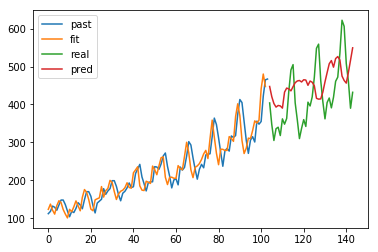

In [30]:
plt.plot(Xpast, label = 'past')
plt.plot(Xfit, label = 'fit')
plt.plot(Xreal, label = 'real')
plt.plot(pd.DataFrame(Xpred, index=Xreal.index), label = 'pred')
plt.legend(loc = 'upper left')

O modelo foi capaz de capturar tanto a sazonalidade quanto a tendência, embora o erro acumulado seja muito alto para o horizonte observado.

__Exercício__: qual o efeito de adicionar dropout às camadas mais prodfundas do modelo. Em particular, avalie o modelo considerando dropout de 20% nas últimas duas camadas (as duas que enxergam mais no passado).

Esta aula foi baseada no material de Krist Papadopoulos, disponível em https://github.com/kristpapadopoulos/seriesnet. Também foi usado material da DeepMind, os criadores da Wavenet, disponível no blog https://deepmind.com/blog/wavenet-generative-model-raw-audio/ e de Joseph Eddy, disponível em https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv/.